In [2]:
# carga de librerias
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv

"""
datos_ventas = ventas agrupadas por canasta 
datos_canasta = "ventas1", ventas individuales sin agrupar y contiene todos los productos comprados
datos_productos = lista de productos y sus códigos
datos_movimientos = contiene los movimientos realizados con fecha y hora x cada producto.
"""
#lectura de rutas
load_dotenv()

pth_venta = os.getenv('VENTAS')
pth_canastas = os.getenv('CANASTAS')
pth_productos = os.getenv('PRODUCTOS')
pth_movimiento = os.getenv('MOVIMIENTOS')

#lectura de archivos de ventas
datos_ventas = pd.read_excel(pth_venta)
datos_canasta = pd.read_excel(pth_canastas)
datos_productos = pd.read_excel(pth_productos)
datos_movimientos = pd.read_excel(pth_movimiento)

In [4]:
#muestra datos de canastas
datos_canasta

#datos_movimientos.head()

,EmpCod,VenNro,PrdCod,VenIteCnt,VenItePrc,VenIteIde
0,1,11,952,1.0,2000,V
1,1,11,975,3.0,1000,V
2,1,11,989,6.0,700,V
3,1,11,1178,1.0,500,V
4,1,12,111,2.0,900,V
...,...,...,...,...,...,...
244368,1,97656,1305,1.0,500,V
244369,1,97656,1687,1.0,2200,V
244370,1,97657,991,1.0,850,V
244371,1,97657,1538,1.0,500,V


In [5]:
#cuales son los tipos de datos
datos_canasta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244373 entries, 0 to 244372
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   EmpCod     244373 non-null  int64  
 1   VenNro     244373 non-null  int64  
 2   PrdCod     244373 non-null  int64  
 3   VenIteCnt  244373 non-null  float64
 4   VenItePrc  244373 non-null  int64  
 5   VenIteIde  244373 non-null  object 
dtypes: float64(1), int64(4), object(1)
memory usage: 11.2+ MB


In [6]:
# existen datos nulos ?
datos_canasta.isnull().sum()

EmpCod       0
VenNro       0
PrdCod       0
VenIteCnt    0
VenItePrc    0
VenIteIde    0
dtype: int64

### 🪣Cuántas canastas diferentes existen

In [7]:
# periodo de análisis

datos = datos_movimientos['MovFch']
print(f'fecha inicio: ' + str(min(datos)))
print(f'fecha final: ' + str(max(datos)))

# números de canastas únicas

print('\nCanastas únicas: ' + str(len(datos_canasta['VenNro'].unique())))

fecha inicio: 2020-08-09 00:00:00
fecha final: 2021-12-03 00:00:00

Canastas únicas: 97646


### 🥫cuántos productos son incluidos en las canastas. 

Se analiza la cantidad de productos, mostrando algunas medidas como, max, min, media, median. Y también de forma gráfica

In [8]:
# agrupar por canasta y contar los productos que existen

datos_canasta.groupby('VenNro').VenNro.count().reset_index(name='CantidadProductos')


,VenNro,CantidadProductos
0,11,4
1,12,14
2,13,1
3,14,1
4,15,1
...,...,...
97641,97653,2
97642,97654,3
97643,97655,1
97644,97656,2


In [9]:
#agrupar datos por N° venta y código de producto. Se suma la cantidad y se cuenta cuántas veces el 
resultado = datos_canasta.groupby(['VenNro','PrdCod']).VenIteCnt.agg(['sum','count'])
print(resultado.head(5))

# verificar si existen cod. productos duplicados en las canastas.
"""
Count, indica si existen duplicidad de cod. de productos
Sum, suma la cantidad vendida por cada cod. de productos
"""
print('\nN° canastas con productos duplicados: ', len(resultado[resultado['count'] >1]))
print('N° canastas sin productos: ', len(resultado[resultado['count'] == 0]))


               sum  count
VenNro PrdCod            
11     952     1.0      1
       975     3.0      1
       989     6.0      1
       1178    1.0      1
12     111     2.0      1

N° canastas con productos duplicados:  0
N° canastas sin productos:  0


In [10]:
"""
Agrupación por canastas únicas.
CantidadProducts, se agrupan por cod. productos
"""
# se agrega la cantidad de productos agrupado
productos_canasta = datos_canasta.groupby('VenNro').agg(
    CantidadProductos=('PrdCod', 'count')
).reset_index()

print(productos_canasta.head(5))

productos_canasta.describe()

   VenNro  CantidadProductos
0      11                  4
1      12                 14
2      13                  1
3      14                  1
4      15                  1


,VenNro,CantidadProductos
count,97646.000000,97646.000000
mean,48834.493743,2.502642
std,28188.127300,2.071666
min,11.000000,1.000000
25%,24423.250000,1.000000
50%,48834.500000,2.000000
75%,73245.750000,3.000000
max,97657.000000,54.000000


Se puede ver desde el resumen, que existen outliers y que se requiere verificar en las siguientes secciones.

C:\Users\darw_\AppData\Local\Temp\ipykernel_39604\3215085479.py:41: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.ecdfplot(base_datos, x='CantidadProductos', palette=['blue'], ax=axes[1])


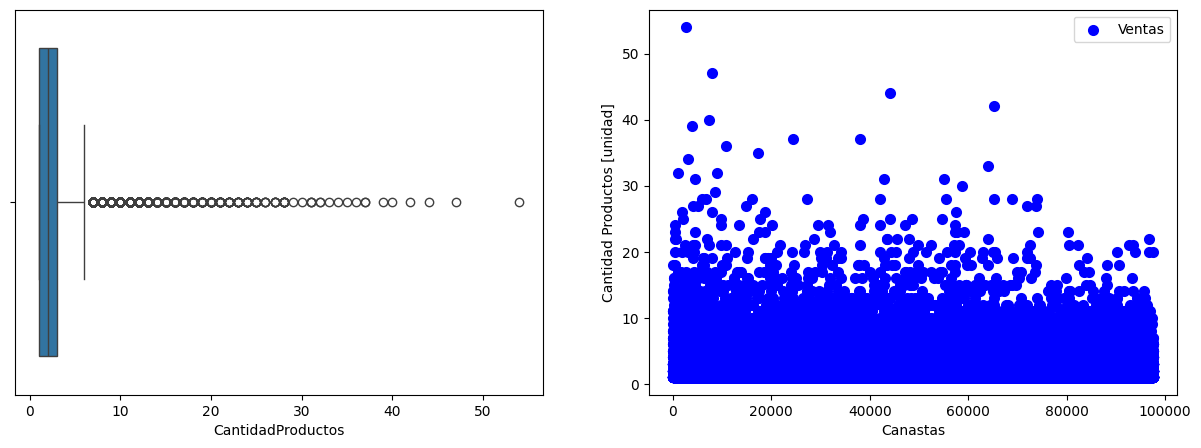

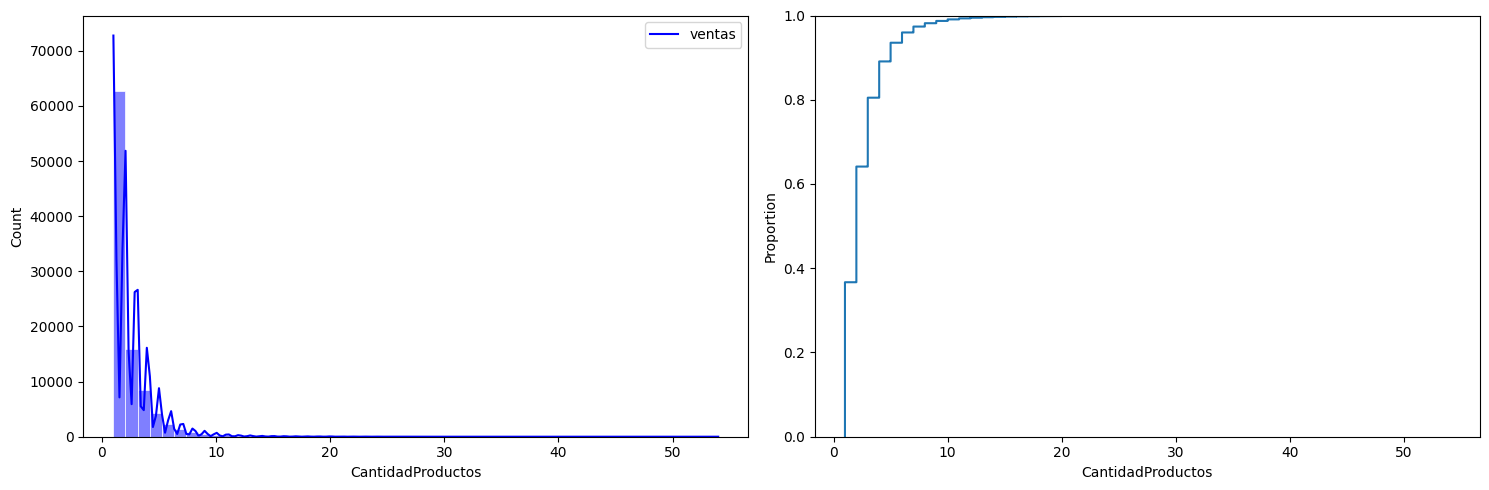

In [11]:
"""
Visualizacion de la distribución de la cantidad de productos en cada canasta.
(izq) gráfico de cajas, (der) scatter
"""

figura_tamaño = (15,5)

fig, axes = plt.subplots(1,2, figsize=figura_tamaño)

# valores a mostrar
x = productos_canasta.index
y = productos_canasta['CantidadProductos']
base_datos = productos_canasta

# muestra boxplot para tag 1 y tag 2
sns.boxplot(data=base_datos, x="CantidadProductos", ax=axes[0])

# grafica los datos 
axes[1].scatter(x, y, linewidth=2.0, color='blue')

plt.xlabel('Canastas') 
plt.ylabel('Cantidad Productos [unidad]') 
plt.legend(["Ventas"], loc="upper right")
plt.show
#---------------------

"""
Visualizacion de la distribución de la cantidad de productos en cada canasta.
(izq) histograma, (der) distribucion acumulativa
"""

fig , axes= plt.subplots(1,2, figsize= figura_tamaño)
axes = axes.ravel()

sns.histplot(y, bins=50, linewidth=0.5, edgecolor="white", color='blue', kde=True, ax=axes[0])
#sns.violinplot(data=base_datos, x="CantidadProductos", ax=axes[0] )
axes[0].legend(["ventas"], loc="upper right")


# distribución acumulativa
sns.ecdfplot(base_datos, x='CantidadProductos', palette=['blue'], ax=axes[1])

fig.tight_layout()
plt.show()

Se puede verificar que +95% de la distribución está entre 1 y 15 productos. Y existen casos con mayor cantidad de productos pero son casos menos probable que son identificados como outliers.
Por lo tanto, se toma la decisión de considerar en un análisis hasta 15 productos.

In [12]:
"""
Filtrado de datos por cantidad de productos en canasta <=15
"""
cantidad_productos = 15
canastas_menor10productos = productos_canasta[productos_canasta['CantidadProductos'] <= cantidad_productos]
canastas_mayor10productos = productos_canasta[productos_canasta['CantidadProductos'] >= cantidad_productos]

print(f'Cantidad canastas menor a {cantidad_productos} productos:', len(canastas_menor10productos))
print(f'Cantidad canastas mayor a {cantidad_productos} productos:', len(canastas_mayor10productos))

#-------------------------- texto a mostrar 
print(f'\ndatos filtrados para menor igual a {cantidad_productos} productos')

datos_filtrados =datos_canasta[datos_canasta['VenNro'].isin(canastas_menor10productos['VenNro'])]
datos_filtrados

Cantidad canastas menor a 15 productos: 97385
Cantidad canastas mayor a 15 productos: 326

datos filtrados para menor igual a 15 productos


,EmpCod,VenNro,PrdCod,VenIteCnt,VenItePrc,VenIteIde
0,1,11,952,1.0,2000,V
1,1,11,975,3.0,1000,V
2,1,11,989,6.0,700,V
3,1,11,1178,1.0,500,V
4,1,12,111,2.0,900,V
...,...,...,...,...,...,...
244368,1,97656,1305,1.0,500,V
244369,1,97656,1687,1.0,2200,V
244370,1,97657,991,1.0,850,V
244371,1,97657,1538,1.0,500,V


### 🚀Productos más vendidos

Se realiza el análisis durante el periodo completo obtenido desde los datos.

In [13]:
import datetime as dt
from datetime import timedelta
"""
Función que permite calcular la cantidad de semanas en los datos analizados
devuelve el n° de semanas
input : dataframe ventas
"""


def semanas_ventas(data_ventas):
    datos = data_ventas['MovFch']
    fecha_inicio =  min(datos)
    fecha_final = max(datos)
    fecha_inicio, fecha_final
    total_dias = (fecha_final- fecha_inicio)/timedelta(days=1)
    return round(total_dias/7)

In [14]:
#cantidad de veces que los cod. productos son comprados
#-------------------------- texto a mostrar 
#Se agrupan los datos por cod. Producto y se cuentan las veces que han comprado el producto

productos_ordenados = datos_filtrados.groupby('PrdCod').PrdCod.count().reset_index(name='vecesComprado').sort_values(by='vecesComprado', ascending=False)
#print(productos_ordenados)


"""
Filtrado de datos por cantidad de ventas al año
se asigna que la mínima frec de ventas a analizar es
un producto debe venderse al menos 2 veces a la semana o 7 días, lunes a domingo.

"""
ventas_porSemanas = 2
ventas_min_año = ventas_porSemanas * semanas_ventas(datos_movimientos)

#filtrado por mínimo de ventas
productos_conMasVentas = productos_ordenados[productos_ordenados['vecesComprado'] >= ventas_min_año]

#filtramos nuevamente la base "datos_filtrados"
#-------------------------- texto a mostrar 
print(f'\ndatos original, tamaño {len(datos_filtrados)}')
datos_filtrados =datos_filtrados[datos_filtrados['PrdCod'].isin(productos_conMasVentas['PrdCod'])]

#-------------------------- texto a mostrar 
print(f'datos filtrados, después, tamaño {len(datos_filtrados)}')
datos_filtrados



datos original, tamaño 238947
datos filtrados, después, tamaño 200967


,EmpCod,VenNro,PrdCod,VenIteCnt,VenItePrc,VenIteIde
1,1,11,975,3.0,1000,V
2,1,11,989,6.0,700,V
3,1,11,1178,1.0,500,V
4,1,12,111,2.0,900,V
5,1,12,965,1.0,1300,V
...,...,...,...,...,...,...
244368,1,97656,1305,1.0,500,V
244369,1,97656,1687,1.0,2200,V
244370,1,97657,991,1.0,850,V
244371,1,97657,1538,1.0,500,V


### 🔝Qué productos son los más comprados, top 10

In [15]:
"""
agrupación de datos por cantidad de veces comprada
y ponderación en las ventas totales

"""
# agrupar por cuántas veces se compró un producto y su acumulado

productos_agrupados = datos_filtrados.groupby('PrdCod').agg(vecesComprado=('PrdCod', 'count')).reset_index().sort_values(by = 'vecesComprado' ,ascending=False)
productos_agrupados['sumaAcumulada'] = productos_agrupados['vecesComprado'].cumsum()
productos_agrupados['porcentaje'] = (productos_agrupados['vecesComprado'].cumsum() / productos_agrupados['vecesComprado'].sum()) * 100
#print(productos_agrupados)

# top 10 productos con mayor cantidad de veces comprados
top=10
producto_top = productos_agrupados.head(top).sort_values(by='vecesComprado', ascending=False)
#.reset_index(drop=True)
print(f'Top {top} productos: ')
producto_top


Top 10 productos: 


,PrdCod,vecesComprado,sumaAcumulada,porcentaje
103,1188,8131,8131,4.045938
277,1627,7665,15796,7.859997
248,1537,4111,19907,9.905606
86,1159,3981,23888,11.886529
152,1269,3631,27519,13.693293
163,1287,3194,30713,15.282609
294,1704,3167,33880,16.858489
257,1559,2982,36862,18.342315
90,1163,2533,39395,19.602721
11,955,2272,41667,20.733255


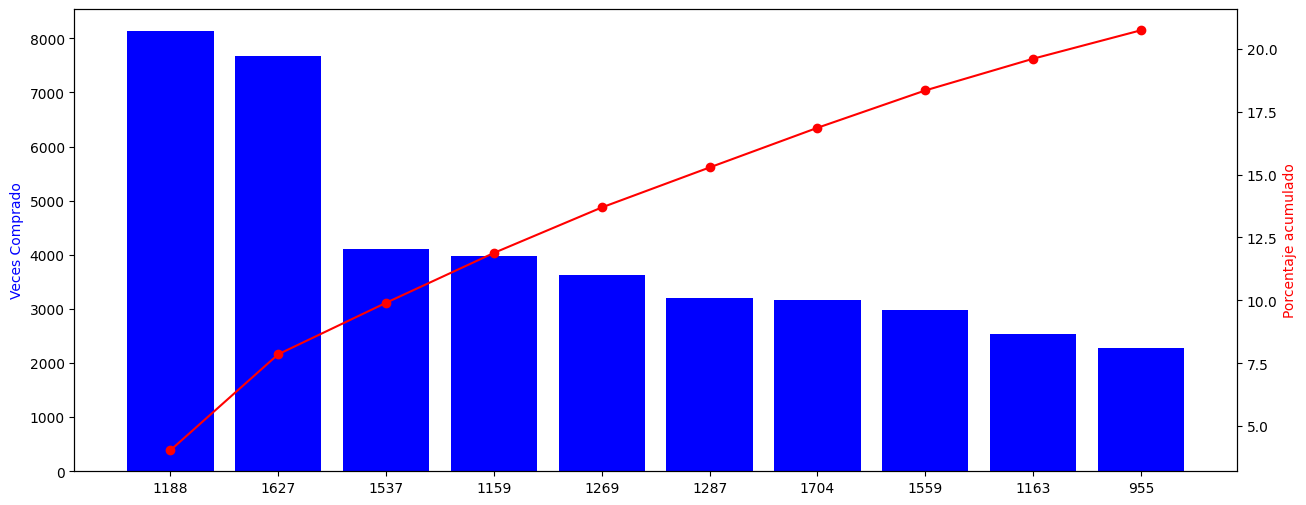

In [16]:
"""
Visualizacion de los productos vendidos ordenados
"""
dframe = producto_top
figura_tamaño = (15,6)
x = 'PrdCod'
y1= 'vecesComprado'
y2= 'sumaAcumulada'
y3 = 'porcentaje'

#convertir desde int a str
dframe[x] = dframe[x].astype('str')

# figura
fig, ax1 = plt.subplots(figsize= figura_tamaño)

# Bar plot
ax1.bar(dframe[x], dframe[y1], color='b')
ax1.set_ylabel('Veces Comprado', color='b')

# Line plot 
ax2 = ax1.twinx()
ax2.plot(dframe[x], dframe[y3], color='r', marker='o')
ax2.set_ylabel('Porcentaje acumulado', color='r')

# mostrar
plt.show()

Distribución de productos y combinaciones de top 10

In [17]:
datos_top_filtrados = datos_filtrados[datos_filtrados['PrdCod'].isin(producto_top['PrdCod'].astype(int))]
pivot_df = datos_top_filtrados.pivot_table(index='VenNro', columns='PrdCod', values='VenIteCnt', aggfunc='sum')
pivot_df


PrdCod,955,1159,1163,1188,1269,1287,1537,1559,1627,1704
VenNro,,,,,,,,,,
45,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,0.050,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
97645,NaN,NaN,NaN,0.805,NaN,NaN,NaN,NaN,NaN,NaN
97650,NaN,NaN,NaN,0.985,NaN,NaN,NaN,NaN,NaN,NaN
97652,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


Cambiar num de producto por nombre

In [18]:
#cambio de num.producto a nombre de producto.
for col in range(len(pivot_df.columns)):
    num_producto = pivot_df.columns[col]
    nombre_producto = datos_productos[datos_productos['PrdCod'] == num_producto]['PrdDsc'].values[0]
    pivot_df.rename(columns={num_producto : nombre_producto}, inplace=True)

#mostrar nueva columna
pivot_df

PrdCod,PRESTIGIO 35 GR NESTLE,AGUA VITAL 600 SIN/GAS,LATA COCA COLA,PAN,CAFE DE MAQUINA,HUEVOS,RED BULL 250 ML,"BEBIDA COCA COLA NORMAL 1,5L",SANDWICH AVE PIMIENTO,HUEVOS DUROS
VenNro,,,,,,,,,,
45,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71,NaN,NaN,NaN,0.050,NaN,NaN,NaN,NaN,NaN,NaN
77,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
97645,NaN,NaN,NaN,0.805,NaN,NaN,NaN,NaN,NaN,NaN
97650,NaN,NaN,NaN,0.985,NaN,NaN,NaN,NaN,NaN,NaN
97652,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


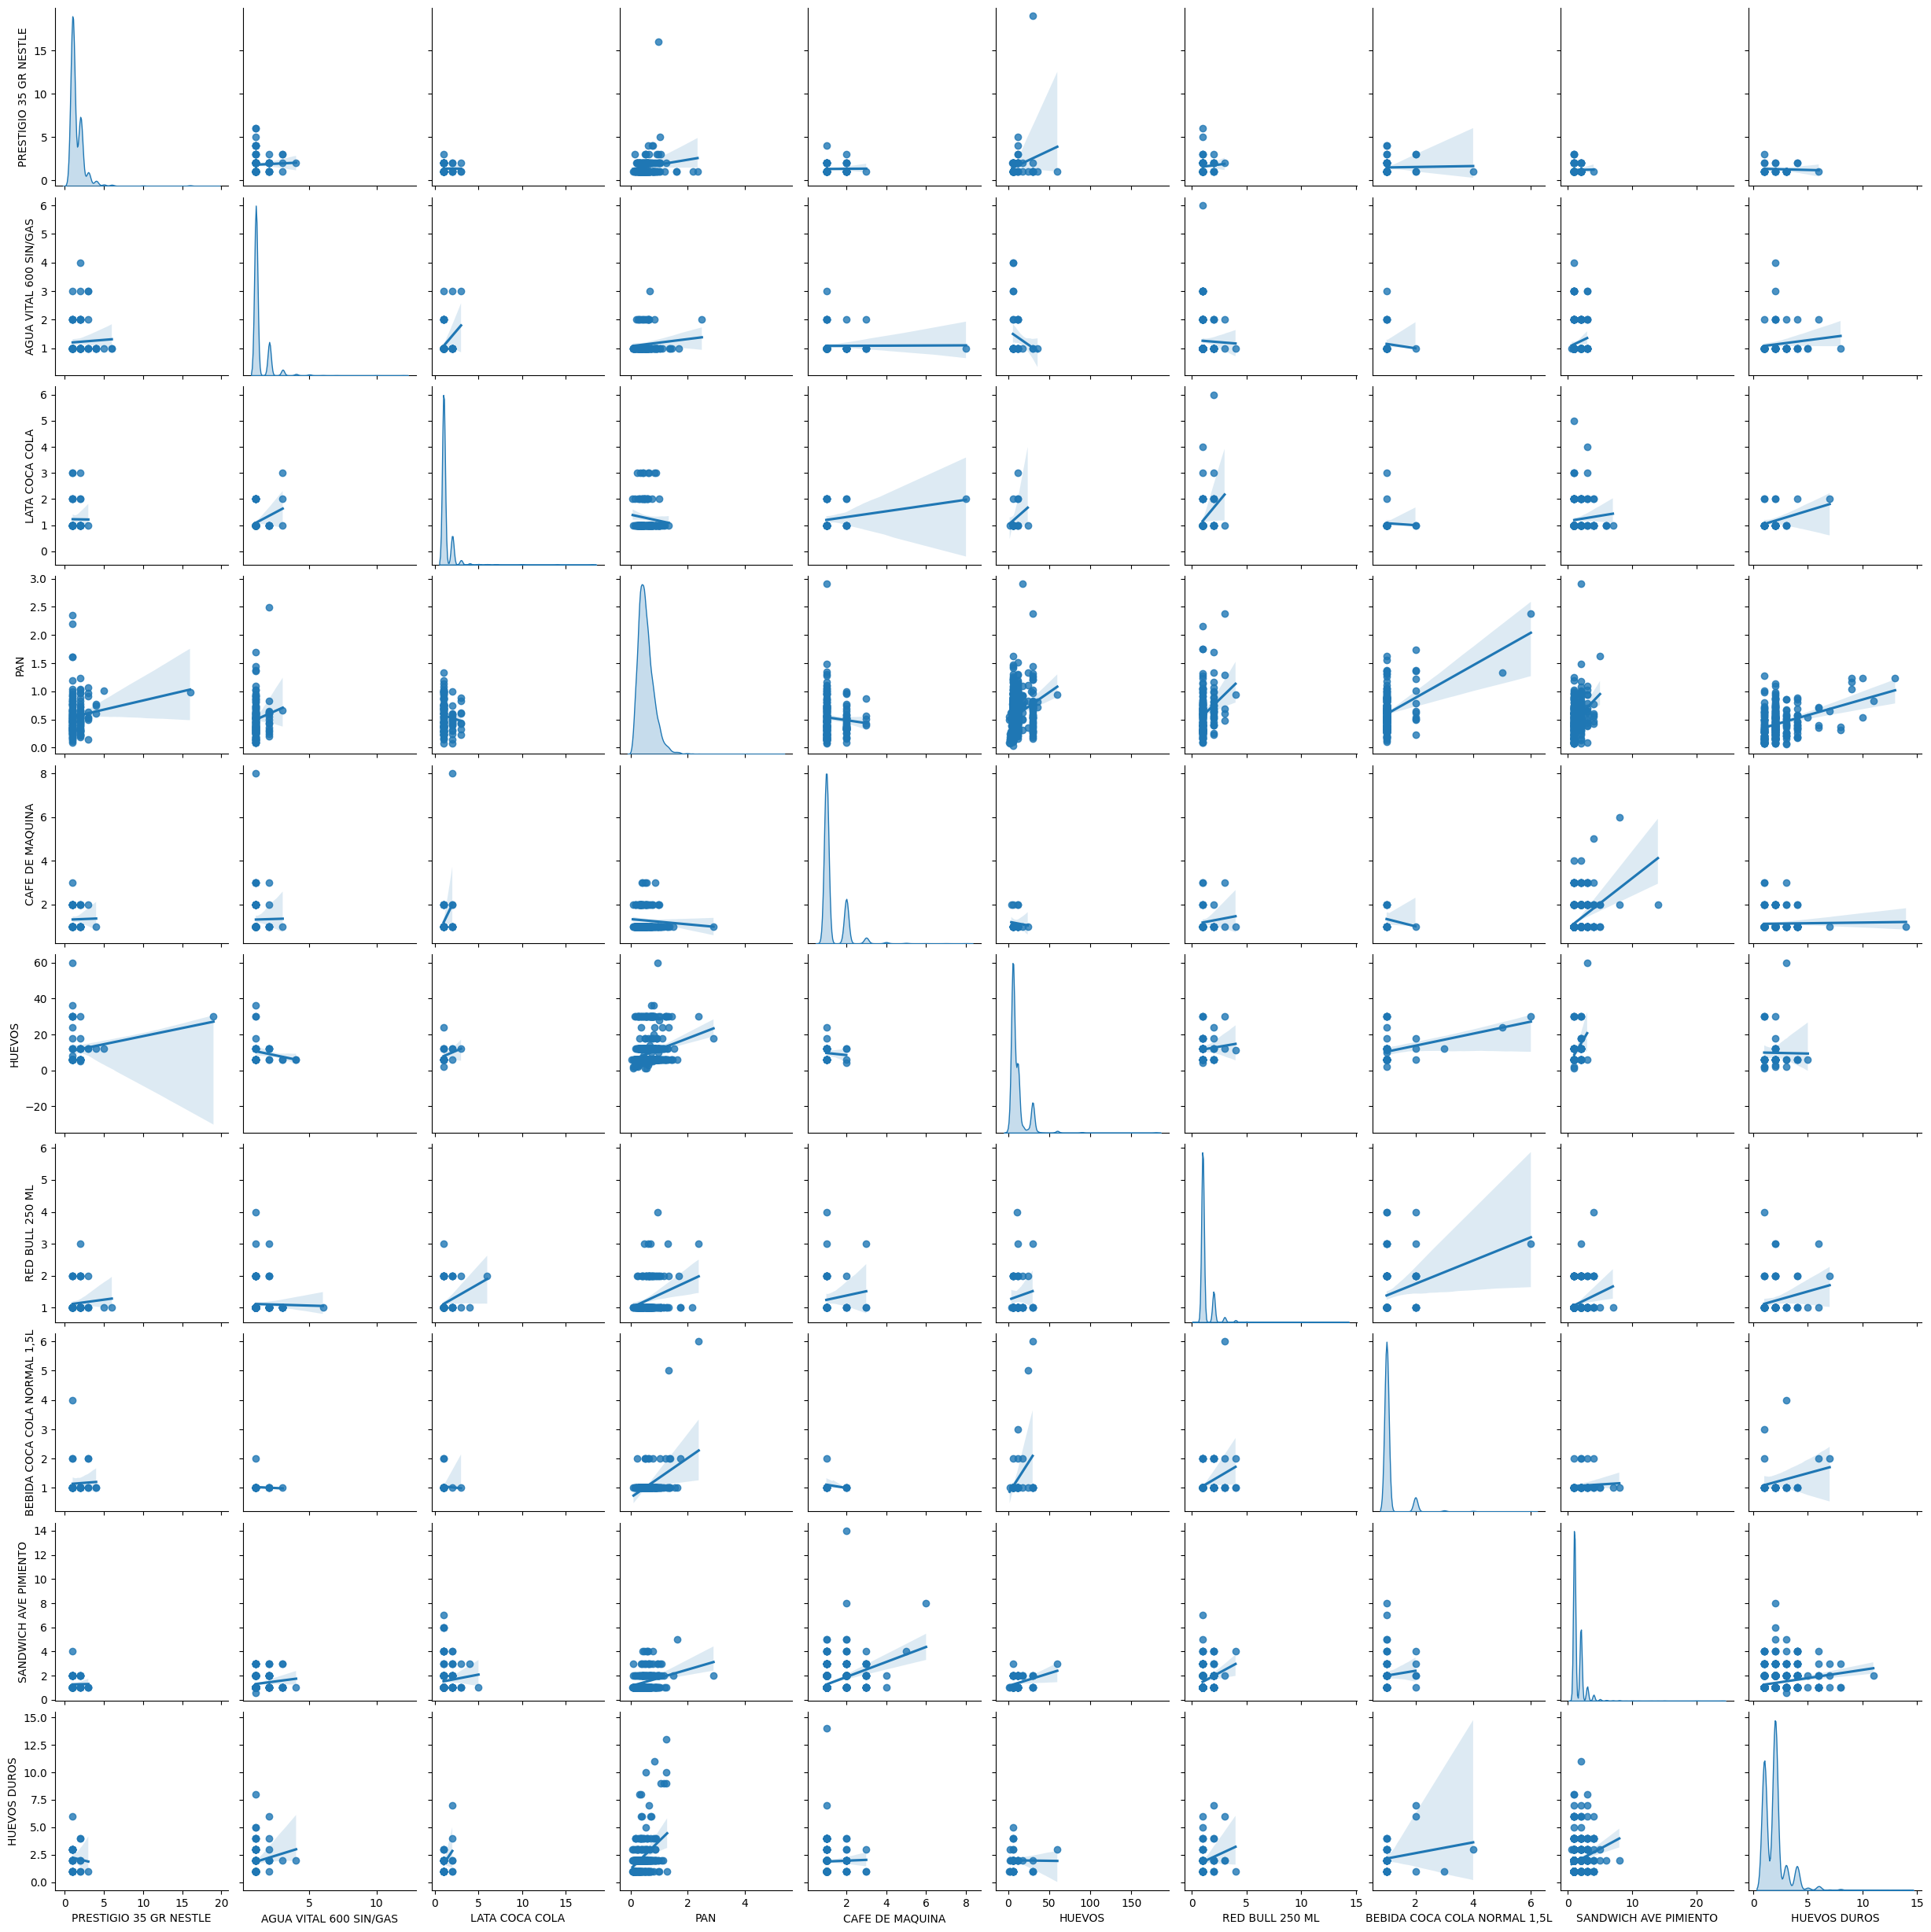

In [117]:
# figura

sns.pairplot(pivot_df, kind="reg", diag_kind='kde')

Correlación de los top 10 productos

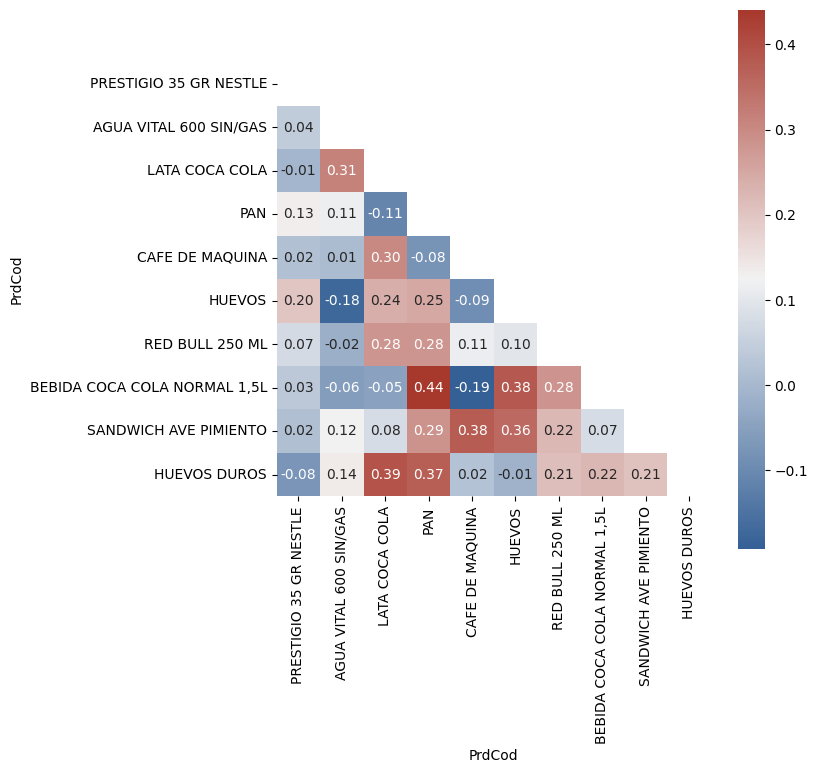

In [34]:
# Crear una paleta de colores
cmap = sns.diverging_palette(250, 15, s=75, l=40, n=9, center="light", as_cmap=True)

# matriz de correlation
matriz_corr = pivot_df.corr(method="pearson")

# Crear una máscara para eliminar triangulo superior de matriz
mask = np.triu(np.ones_like(matriz_corr, dtype=bool))

fig, ax = plt.subplots(figsize=(7, 7))
sns.heatmap(matriz_corr, mask=mask, cmap=cmap, square=True, annot=True, fmt=".2f", ax=ax)
plt.show()

### 🛰️Cuándo las personas compran, análisis por horario

In [34]:
"""
datos_ventas = ventas agrupadas por canasta 
datos_ventas1 = ventas individuales sin agrupar y contiene todos los productos comprados
datos_productos = lista de productos y sus códigos
datos_movimientos = contiene los movimientos realizados con fecha y hora x cada producto

"""

# transformación de datos para data tipo time
datos_ventas['VenHor'] = pd.to_datetime(datos_ventas['VenHor'], format='%H:%M:%S')
datos_ventas.head(5)

,EmpCod,VenNro,VenFch,PerCod,CueCod,PagCod,VenTip,VenDsc,VenHor,VenPro,VenCieDia,VenCieFol,CliCod,VenTipVen,VenPagMon,VenPagCod2,VenPagMon2,VenPagCod3,VenPagMon3
0,1,11,2020-08-09,2,1,1,NaN,0,1900-01-01 18:53:34,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN
1,1,12,2020-08-09,2,1,4,NaN,0,1900-01-01 19:10:05,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN
2,1,13,2020-08-09,2,1,1,NaN,0,1900-01-01 19:12:50,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN
3,1,14,2020-08-09,2,1,1,NaN,0,1900-01-01 19:14:52,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN
4,1,15,2020-08-09,2,1,1,NaN,0,1900-01-01 19:16:49,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN


In [35]:
datos_ventas.head(5)

,EmpCod,VenNro,VenFch,PerCod,CueCod,PagCod,VenTip,VenDsc,VenHor,VenPro,VenCieDia,VenCieFol,CliCod,VenTipVen,VenPagMon,VenPagCod2,VenPagMon2,VenPagCod3,VenPagMon3
0,1,11,2020-08-09,2,1,1,NaN,0,1900-01-01 18:53:34,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN
1,1,12,2020-08-09,2,1,4,NaN,0,1900-01-01 19:10:05,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN
2,1,13,2020-08-09,2,1,1,NaN,0,1900-01-01 19:12:50,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN
3,1,14,2020-08-09,2,1,1,NaN,0,1900-01-01 19:14:52,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN
4,1,15,2020-08-09,2,1,1,NaN,0,1900-01-01 19:16:49,0,C,0.0,0,V,0,NaN,NaN,NaN,NaN


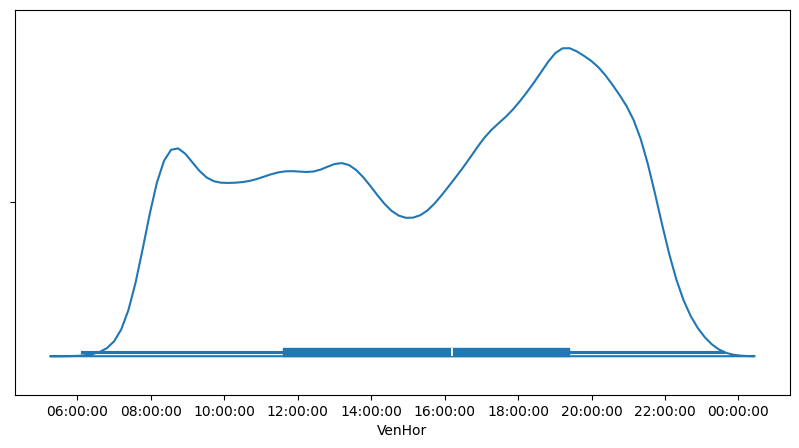

In [36]:
"""
mostrar como es la distribución según horario de las compras 
"""

#libraries
from matplotlib.dates import DateFormatter

# figura
figura_tamaño = (10,5)
fig, ax1 = plt.subplots(figsize= figura_tamaño)
sns.violinplot(x='VenHor', data=datos_ventas, fill=False, split=True)

# Formato para mostrar solo el tiempo en eje x
date_format = DateFormatter('%H:%M:%S')
plt.gca().xaxis.set_major_formatter(date_format)

* El 75% de las compras se realizan entre las 12hrs y 19: hrs
* Existen dos peak, mañana: 8:30 hrs, y tarde: 19:30 hrs
* Cerca de las 15:00 hrs es el periodo que las personas compran menos.

### ⏳Qué productos no sean comprado

In [27]:
productos_comprados = datos_productos.PrdCod.unique()
productos_baseDatos = datos_canasta.PrdCod.unique()

print(f" Hay {len(productos_comprados) - len(productos_baseDatos)} productos que no fueron comprados")

 Hay 33 productos que no fueron comprados


In [57]:
#lista de productos no comprados.
productos_noComprados = set(productos_comprados) - set(productos_baseDatos)
productos_noComprados = list(productos_noComprados)
lista =[]
for x in productos_noComprados:
    nombre_producto = datos_productos[datos_productos['PrdCod'] == x]['PrdDsc'].values[0]
    lista.append(nombre_producto)
pd.DataFrame(lista, columns=['productos'])

,productos
0,FERRERO ROCHER 12 UN 150 GR
1,ALFOMBRAS Y FUNDAS DE NAVIDAD
2,QUESO PARMESANO
3,"CHAMPION DOG PREMIUM 2,7"
4,PEREJIL
5,PASTEL DE CHOCLO
6,BIO FRESCURA POLVO 800GR
7,CHAMPIÑONES
8,ALFAJOR
9,PACK NECTAR SPRIM DURAZNO 200CC


Estos productos deben verificarse si corresponden a etiquetas no usadas, dualidad de productos, o errores de ingreso.